## Introduction

In this notebook we'll develop an exploratory data analysis with real estate data from a brazilian city named Belo Horizonte. The extraction of the data was made with Scrapy and Selenium, and performed by November 2021.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import folium
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("../input/house-pricing-in-belo-horizonte/data.csv")

---

## Basic Explorations and Data Cleaning

#### What is the percentage of null values per column?

In [3]:
np.round((df.isna().sum() / df.shape[0]) * 100, 2)

address           0.00
adm-fees         33.51
garage-places     0.00
price             0.50
rooms             0.00
square-foot       0.00
neighborhood      0.40
city              0.00
latitude          0.00
longitude         0.00
dtype: float64

As we saw, only one column has a significant amount of null values. This column regards costs that usually are related to condominiums. In that case, the absence of cost represents no cost at all and, hence, there's no information loss.

The remaining two fields with null values, on the other hand, might be problematic. For the purpose of this analysis, I decided to simply discard every item without an aggregated `price`. However, records with missing `neighborhoods` will be kept.

In [4]:
df.dropna(subset=["price"], inplace=True)

### How does the price distribution looks like?

In [5]:
df.price.describe()

count    5.951000e+03
mean     1.075036e+06
std      2.127474e+06
min      4.500000e+02
25%      3.900000e+05
50%      6.800000e+05
75%      1.210000e+06
max      1.300000e+08
Name: price, dtype: float64

Apparently, and not surprisingly, there are some pretty extreme outliers in the data. For the purpose of this analysis, lets consider only data points bellow the 95-th percentile.

In [6]:
print(f"The most expensive house worths R$ {df.price.max()}")

The most expensive house worths R$ 130000000.0


In [7]:
df_wo_outliers = df[df.price < df.price.quantile(0.95)]

There are also strangely small values that wouldn't be enough to buy some dogs' houses, what quite probably are errors. Hence, let's establish a pertinent minimum value to filter on the dataframe (for example, 100k).

In [8]:
print(f"The cheapest property worths R$ {df.price.min()}")

The cheapest property worths R$ 450.0


In [9]:
df_wo_outliers = df_wo_outliers[df_wo_outliers.price >= 1e5]

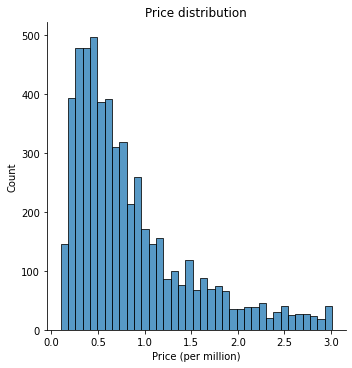

In [10]:
sns.displot(df_wo_outliers.price/1e6)
plt.title("Price distribution")
plt.xlabel("Price (per million)")

plt.show()

After this quick filtering, how many points there left in the data?

In [11]:
print(f"There's still {df_wo_outliers.shape[0]} properties")

There's still 5536 properties


### How does the distribution of rooms look like?

In [12]:
df_wo_outliers.rooms.value_counts().sort_index()

--      388
1       201
1-2       2
10        1
12        1
15        1
18        1
2      1224
2-3      12
3      2136
3-4       2
4      1402
4-5       1
5       123
6        26
7         7
8         5
9         3
Name: rooms, dtype: int64

As we can see, there are records where the number of rooms is not informed, whereas others inform more than one value. Since both cases can be source of uncertainty, lets just remove these items and see what we get.

In [13]:
df_wo_outliers = df_wo_outliers[~df_wo_outliers.rooms.str.contains('-')]

In [14]:
df_wo_outliers["rooms"] = df_wo_outliers["rooms"].astype(int)

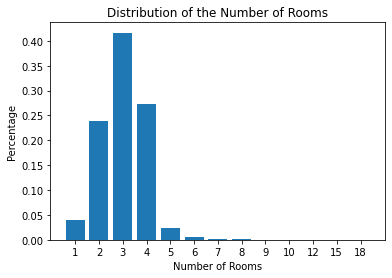

In [15]:
rooms_count = df_wo_outliers.rooms.value_counts().sort_index()

plt.bar([str(value) for value in rooms_count.index], rooms_count.values/df_wo_outliers.shape[0])
plt.title("Distribution of the Number of Rooms")
plt.xlabel("Number of Rooms")
plt.ylabel("Percentage")
plt.show()

How many data points there's left in the dataset?

In [16]:
print(f"There's still {df_wo_outliers.shape[0]} properties")

There's still 5131 properties


### How is the distribution of `Garage Places` and `Square Footage`?

In [17]:
df_wo_outliers = df_wo_outliers[
    (~df_wo_outliers["square-foot"].str.contains('-'))
    & (~df_wo_outliers["garage-places"].str.contains('-'))
]

df_wo_outliers.loc[:, ["garage-places", "square-foot"]] = (
    df_wo_outliers[["garage-places", "square-foot"]].astype(int)
)

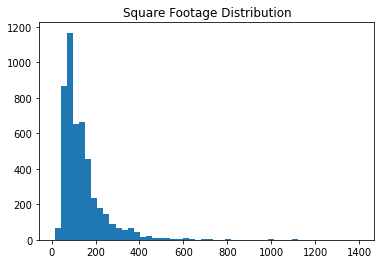

In [18]:
plt.hist(df_wo_outliers["square-foot"], bins=50)
plt.title("Square Footage Distribution")
plt.show()

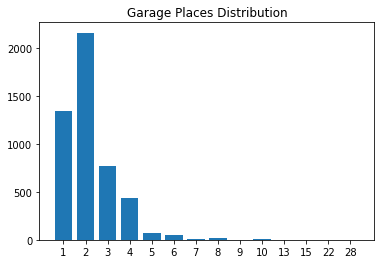

In [19]:
garage_counts = df_wo_outliers["garage-places"].value_counts().sort_index()

plt.bar([str(label) for label in garage_counts.index], garage_counts.values)
plt.title("Garage Places Distribution")
plt.show()

In [20]:
print(f"There's still {df_wo_outliers.shape[0]} properties")

There's still 4869 properties


---

## More Advanced Analysis

In this slightly more complex analysis, we'll dive a little bit into the statistics from each neighrborhood, and cost-benefit investigations. Initially, lets just remove every record without the neighborhood specification.

In [21]:
df_wo_outliers.dropna(subset=["neighborhood"], inplace=True)
df_wo_outliers["adm-fees"] = df_wo_outliers["adm-fees"].fillna(0)

print(f"There's still {df_wo_outliers.shape[0]} properties")

There's still 4851 properties


In [22]:
print(f"There are {df_wo_outliers.neighborhood.nunique()} different neighborhood")

There are 201 different neighborhood


Now we are ready to go. As we can see, there is still a considerable amount of properties in our dataframe.

### What is the top 5 least expensive neighborhoods?

In [23]:
def mode(s):
    return s.value_counts().index[0]

In [24]:
grouped_by_neighborhood = (
    df_wo_outliers.groupby("neighborhood")
    .agg(
        {
            "price": "median",
            "garage-places": mode,
            "rooms": mode,
            "square-foot": "median",
            "adm-fees": "median"
        }
    )
)

In [25]:
cols = ["price", "square-foot", "rooms", "garage-places", "adm-fees"]

grouped_by_neighborhood = grouped_by_neighborhood.sort_values(
    by=cols,
    ascending=[
        True,
        False,
        False,
        False,
        True
    ]
)

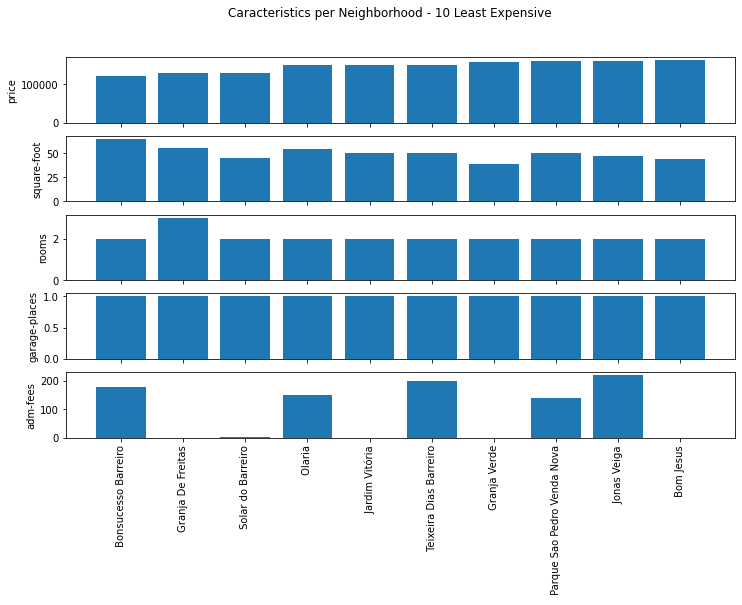

In [26]:
figure, axs = plt.subplots(5, 1, sharex=True, figsize=(12,7))

top10 = grouped_by_neighborhood.iloc[:10]
for i, col in enumerate(cols):
    axs[i].bar(top10.index, top10[col].values)
    axs[i].set_ylabel(col)

plt.xticks(rotation=90)
figure.suptitle("Caracteristics per Neighborhood - 10 Least Expensive")
plt.show()

The previous plots suggests that most of the properties in cheaper neighborhood are similar in their characteristics. We can derive an important information with the visualization of `adm-fees` column. Since 6 out of 10 neighborhoods have a median value equal to zero, we mgith expect such places to have bigger numbers of apartments instead of houses (or condominium houses) in sale. Considering only condominium properties to have administrative costs.

### What is the top 5 most expensive neighborhoods?

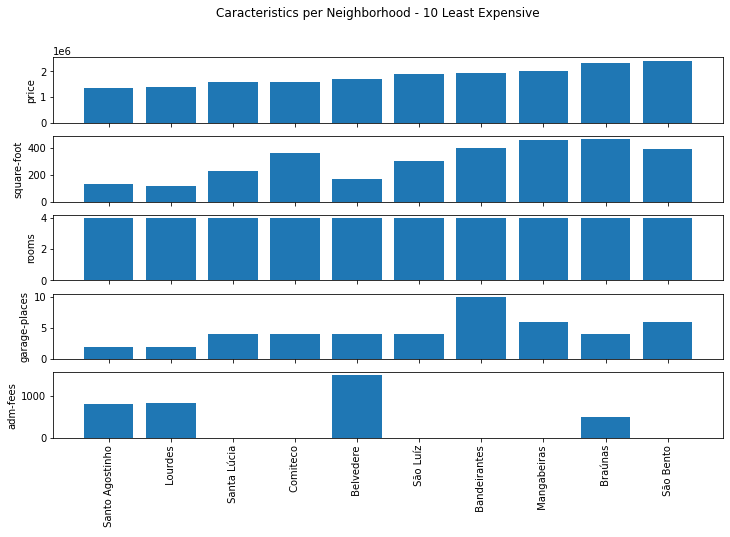

In [27]:
figure, axs = plt.subplots(5, 1, sharex=True, figsize=(12,7))

top10 = grouped_by_neighborhood.iloc[-10:]
for i, col in enumerate(cols):
    axs[i].bar(top10.index, top10[col].values)
    axs[i].set_ylabel(col)

plt.xticks(rotation=90)
figure.suptitle("Caracteristics per Neighborhood - 10 Least Expensive")
plt.show()

In the most expensive places, on the other hand, we have a bit more differentiation. Differently, from the least expensive neighborhoods, here we have a predominance of houses instead of apartments, and no property with only one garage place.

### What is the least expensive square meter?

In [28]:
df_wo_outliers["price-m2"] = df_wo_outliers["price"] / df_wo_outliers["square-foot"]
grouped_m2_price = df_wo_outliers.groupby("neighborhood").agg({"price-m2": "mean"}).sort_values(by="price-m2")

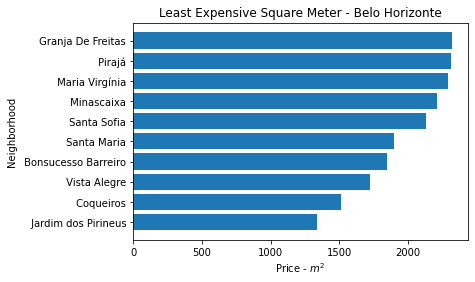

In [29]:
plt.barh(grouped_m2_price[:10].index, grouped_m2_price[:10].values.reshape(-1))
plt.title("Least Expensive Square Meter - Belo Horizonte")
plt.xlabel("Price - $m^2$")
plt.ylabel("Neighborhood")
plt.show()

### What is the most expensive square meter?

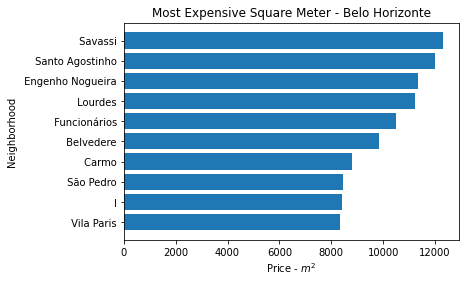

In [30]:
plt.barh(grouped_m2_price[-10:].index, grouped_m2_price[-10:].values.reshape(-1))
plt.title("Most Expensive Square Meter - Belo Horizonte")
plt.xlabel("Price - $m^2$")
plt.ylabel("Neighborhood")
plt.show()

### What is the average price per property type (House or Apartment)?

In [31]:
df_wo_outliers["property-type"] = "Apartment"
df_wo_outliers.loc[df_wo_outliers["adm-fees"] == 0, "property-type"] = "House"

In [32]:
df_wo_outliers.groupby("property-type")["price-m2"].mean()

property-type
Apartment    6906.140700
House        6712.421233
Name: price-m2, dtype: float64

Interestingly, it seems that the square meter price for apartments is more expensive than for houses.

In [33]:
df_wo_outliers.groupby("property-type")["price"].mean()

property-type
Apartment    843576.577117
House        972567.045914
Name: price, dtype: float64

Nonetheless, the average price for house properties is bigger.

### Directed Analysis

Now lets just take a quick look at the records and see what is the greatest properties according to some specific characteristics

In [34]:
n_rooms = 3
n_garage_places = 2

In [35]:
df_wo_outliers = df_wo_outliers[
    (df_wo_outliers["rooms"] >= n_rooms)
    & (df_wo_outliers["garage-places"] >= n_garage_places)
]

In [36]:
min_price = 250000
max_price = 420000

df_ap = df_wo_outliers[
    (df_wo_outliers["property-type"] == "Apartment")
    & (df_wo_outliers["price"].between(min_price, max_price))
]
df_ap = df_ap.sort_values(by=["square-foot", "price"], ascending=[False, True]).iloc[:10]

A geographic visualization of the top 10 greatest apartments in terms of square footage and price

**NOTE: by clicking on the pins we are able to see more informations about the property beeing analyzed**

In [37]:
ap_map = folium.Map(location=[-19.913948065929585, -43.951483374892256], zoom_start=11)

for _, row in df_ap.iterrows():
    folium.Marker(
        location=[
            row.latitude,
            row.longitude],
        popup=f" n_rooms: {row.rooms}\n price: {row.price}\n neighborhood: {row.neighborhood}"
    ).add_to(ap_map)

ap_map

In [38]:
min_price = 350000
max_price = 500000

df_house = df_wo_outliers[
    (df_wo_outliers["property-type"] == "House")
    & (df_wo_outliers["price"].between(min_price, max_price))
]
df_house = df_house.sort_values(by=["square-foot", "price"], ascending=[False, True]).iloc[:10]

A geographic visualization of the top 10 greatest houses in terms of square footage and price

In [39]:
house_map = folium.Map(location=[-19.913948065929585, -43.951483374892256], zoom_start=11)

for _, row in df_house.iterrows():
    folium.Marker(
        location=[
            row.latitude,
            row.longitude],
        popup=f" n_rooms: {row.rooms}\n price: {row.price}\n neighborhood: {row.neighborhood}"
    ).add_to(house_map)

house_map

---
## Conclusion

So, that's it. Here we went through some exploratory data analysis over the dataset I've scrapped on a real estate site with Belo Horizonte's properties. We saw some very interesting characteristics such as bigger structural differences on more expensive properties, as well as a tendency to have more houses than apartments in the more expensive neighborhoods.

I also intend to perform further improvements in the dataset (aggregating external sources) so we become able to perform deeper analysis with regard to life quality, and criminality of the neighborhoods.


Thanks for the reading. Any feedback is more than welcome. If you enjoyed, please give a thumbs up.